In [1]:
import cartopy.crs as ccrs
import intake
import numpy as np
import xarray as xr
from tqdm.autonotebook import tqdm
import pyremo as pr
import cordex as cx
import cmaps
import glob
import xesmf as xe
from REMO2020_mod import modelclass, prepare_hcorrection, season_mean, eobs_temp_open, open_mfdataset, cut_rotated, domainclass, plotclass, remo_plotter

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300096/Python/envs/kernel2023/share/proj failed
/tmp/ipykernel_1831443/4163117478.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
from dask.distributed import Client, progress
import dask
dask.config.set({'temporary_directory': '/scratch/g/g300096/dask/tmp'})
client = Client()
client

/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34941 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300096/levante-spawner-preset//proxy/34941/status,
Dashboard: /user/g300096/levante-spawner-preset//proxy/34941/status,Workers: 16
Total threads: 256,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39883,Workers: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/34941/status,Total threads: 256
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:38203,Total threads: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/36029/status,Memory: 14.71 GiB
Nanny: tcp://127.0.0.1:36407,


In [3]:
# define the runs to be plotted
modelruns =[] # init

modelruns.append(modelclass("056524","REMO2015",False,varname='Dtemp2'))
modelruns.append(modelclass("036030","REMO2020$_{27}$",True,varname='Dtemp2'))
modelruns.append(modelclass("036032","REMO2020$_{49}$",True,varname='Dtemp2'))
modelruns.append(modelclass("036034","REMO2020$_{49}$ MERRA-2",True,varname='Dtemp2'))
modelruns.append(modelclass("036039","REMO2020$_{49}$ iMOVE",True,varname='Dtemp2'))

In [4]:
# give path, prefix and suffix (the main name for the plots)
figpath = './figures/'
prefix = 'eobs_temp_seas_'
suffix = 'REMO2020_2749_main'

In [5]:
# REMO and EOBS datapath
rdata = './data_in/model_data/'
edata = './data_in/E-OBS/'

In [6]:
# define star year and end year
ystart=2001
yend=2010

In [7]:
# Define the order of seasons to be used (also when plotting)
seasons = ["DJF","MAM","JJA","SON"]

In [8]:
# Load the lake mask
lake_mask = xr.open_dataset(rdata+"FLake_input/flake_v3_glcc_defD10.0m_frac_EUR-11.nc")["FLFRA"]

In [9]:
# E-OBS version
eobv='v30.0e'

In [10]:
# set the minimum number days with data per month to be included
dlim=21

In [11]:
# lake fraction cut-off limit
clake = 0.5

In [12]:
# Target grid
trggrid = "EUR-11"

In [13]:
# Define topography files
remotopofile = rdata+"REMO_static/FIB_EUR-11.nc"
eobstopofile = edata+eobv+"/fx/var/elev/elev_ens_0.1deg_reg_"+eobv+".nc"

In [14]:
# Get height correction and regridder for EOBS
hcorrection, regridder = prepare_hcorrection(remotopofile,eobstopofile)

In [15]:
# Eobs file name
eobsfile = edata+eobv+"/day/var/tg/tg_ens_mean_0.1deg_reg_"+eobv+".nc"

In [16]:
# calculate eobs variables and take the height correction into account
var = "tg" # name of the variable to be read in
eobs_mdata, final_mask = eobs_temp_open(var,eobsfile,ystart,yend,hcorrection,regridder,dlim,lake_mask,clake)

/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 201. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 464. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 20.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large gra

In [17]:
yearlist = np.arange(ystart,yend+1)
for obj in modelruns:
    obj.filenames = []
    for year in yearlist:
        pattern = rdata+"remo_results_"+obj.userexp+"/"+str(year)+"/e"+obj.userexp+"m*.nc"
        obj.filenames += glob.glob(pattern)
    obj.filenames.sort()

In [18]:
# Set halo zone length (will be cutted out)
halo = 8

In [19]:
# calculate the T2m difference to EOBS
ii = 0
for obj in modelruns:
    ds = open_mfdataset(obj.filenames, parallel=False, chunks='auto')
    t2m = pr.parse_dates(ds.TEMP2) # has the 2-meter dimension and its name might change. Luckily it is in position 1 and we can remove it
    t2m = t2m.squeeze(dim=t2m.dims[1],drop=True)
    # Merge data (get identical coordinates)
    t2m_all = xr.merge([t2m, final_mask.rename("mask"), eobs_mdata.rename("eobs_m_data")], compat="override", join="override")
    # Calculate absolute values
    if(ii == 0):
        abs_vals = t2m_all[["eobs_m_data"]].where(t2m_all.mask, drop=False).compute()
        abs_vals_mean = season_mean(abs_vals).eobs_m_data
        abs_vals_mean = abs_vals_mean.where(abs_vals_mean > 0.0, drop=False) # remove zeros
        abs_vals_mean = abs_vals_mean.isel(rlat=slice(halo+1,abs_vals_mean.sizes["rlat"]-halo+1), rlon=slice(halo+1,abs_vals_mean.sizes["rlon"]-halo+1)).compute()
    # get identical coordinates
    final_tmp = xr.merge([t2m_all,abs_vals.eobs_m_data.rename("abs_vals")], compat="override", join="override")
    # apply masking (eobs+lake) and subtract the values, finally making seasonal means
    obj.vardiff = season_mean(final_tmp.TEMP2.where(final_tmp.mask,drop=False) - final_tmp.abs_vals).squeeze()
    obj.vardiff = obj.vardiff.isel(rlat=slice(halo+1,obj.vardiff.sizes["rlat"]-halo+1), rlon=slice(halo+1,obj.vardiff.sizes["rlon"]-halo+1)).compute()
    # not supported, set to zero
    obj.mask = np.zeros(len(seasons))
    # Increase counter
    ii = ii + 1
    #t_stat
    if(obj.r2020file):
        pole = (ds.rotated_latitude_longitude.grid_north_pole_longitude,ds.rotated_latitude_longitude.grid_north_pole_latitude)
        rotated_pole = ccrs.RotatedPole(pole[0], pole[1])
        extent = ([ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()], rotated_pole)
    # clean memory
    del ds, t2m, t2m_all, final_tmp
# clean memory
del eobs_mdata, abs_vals

/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 257.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

In [20]:
# define the domains to be plotted
domaininfo =[] # init
domaininfo.append(domainclass("EU",[-22.5,47.5,30,72.5], hspace=0.35))

In [21]:
# define plotclasses for absolute and difference (model) plots
absplotc = plotclass(label='T [K]', lspace=np.linspace(0,1,32), vmin=260, vmax=300, linvert=False, cmapp=cmaps.BlAqGrYeOrReVi200)
modplotc = plotclass(label='$\Delta$T [K]', lspace=np.linspace(0,1,16), vmin=-4, vmax=4, linvert=False, cmapp=cmaps.BlueWhiteOrangeRed)

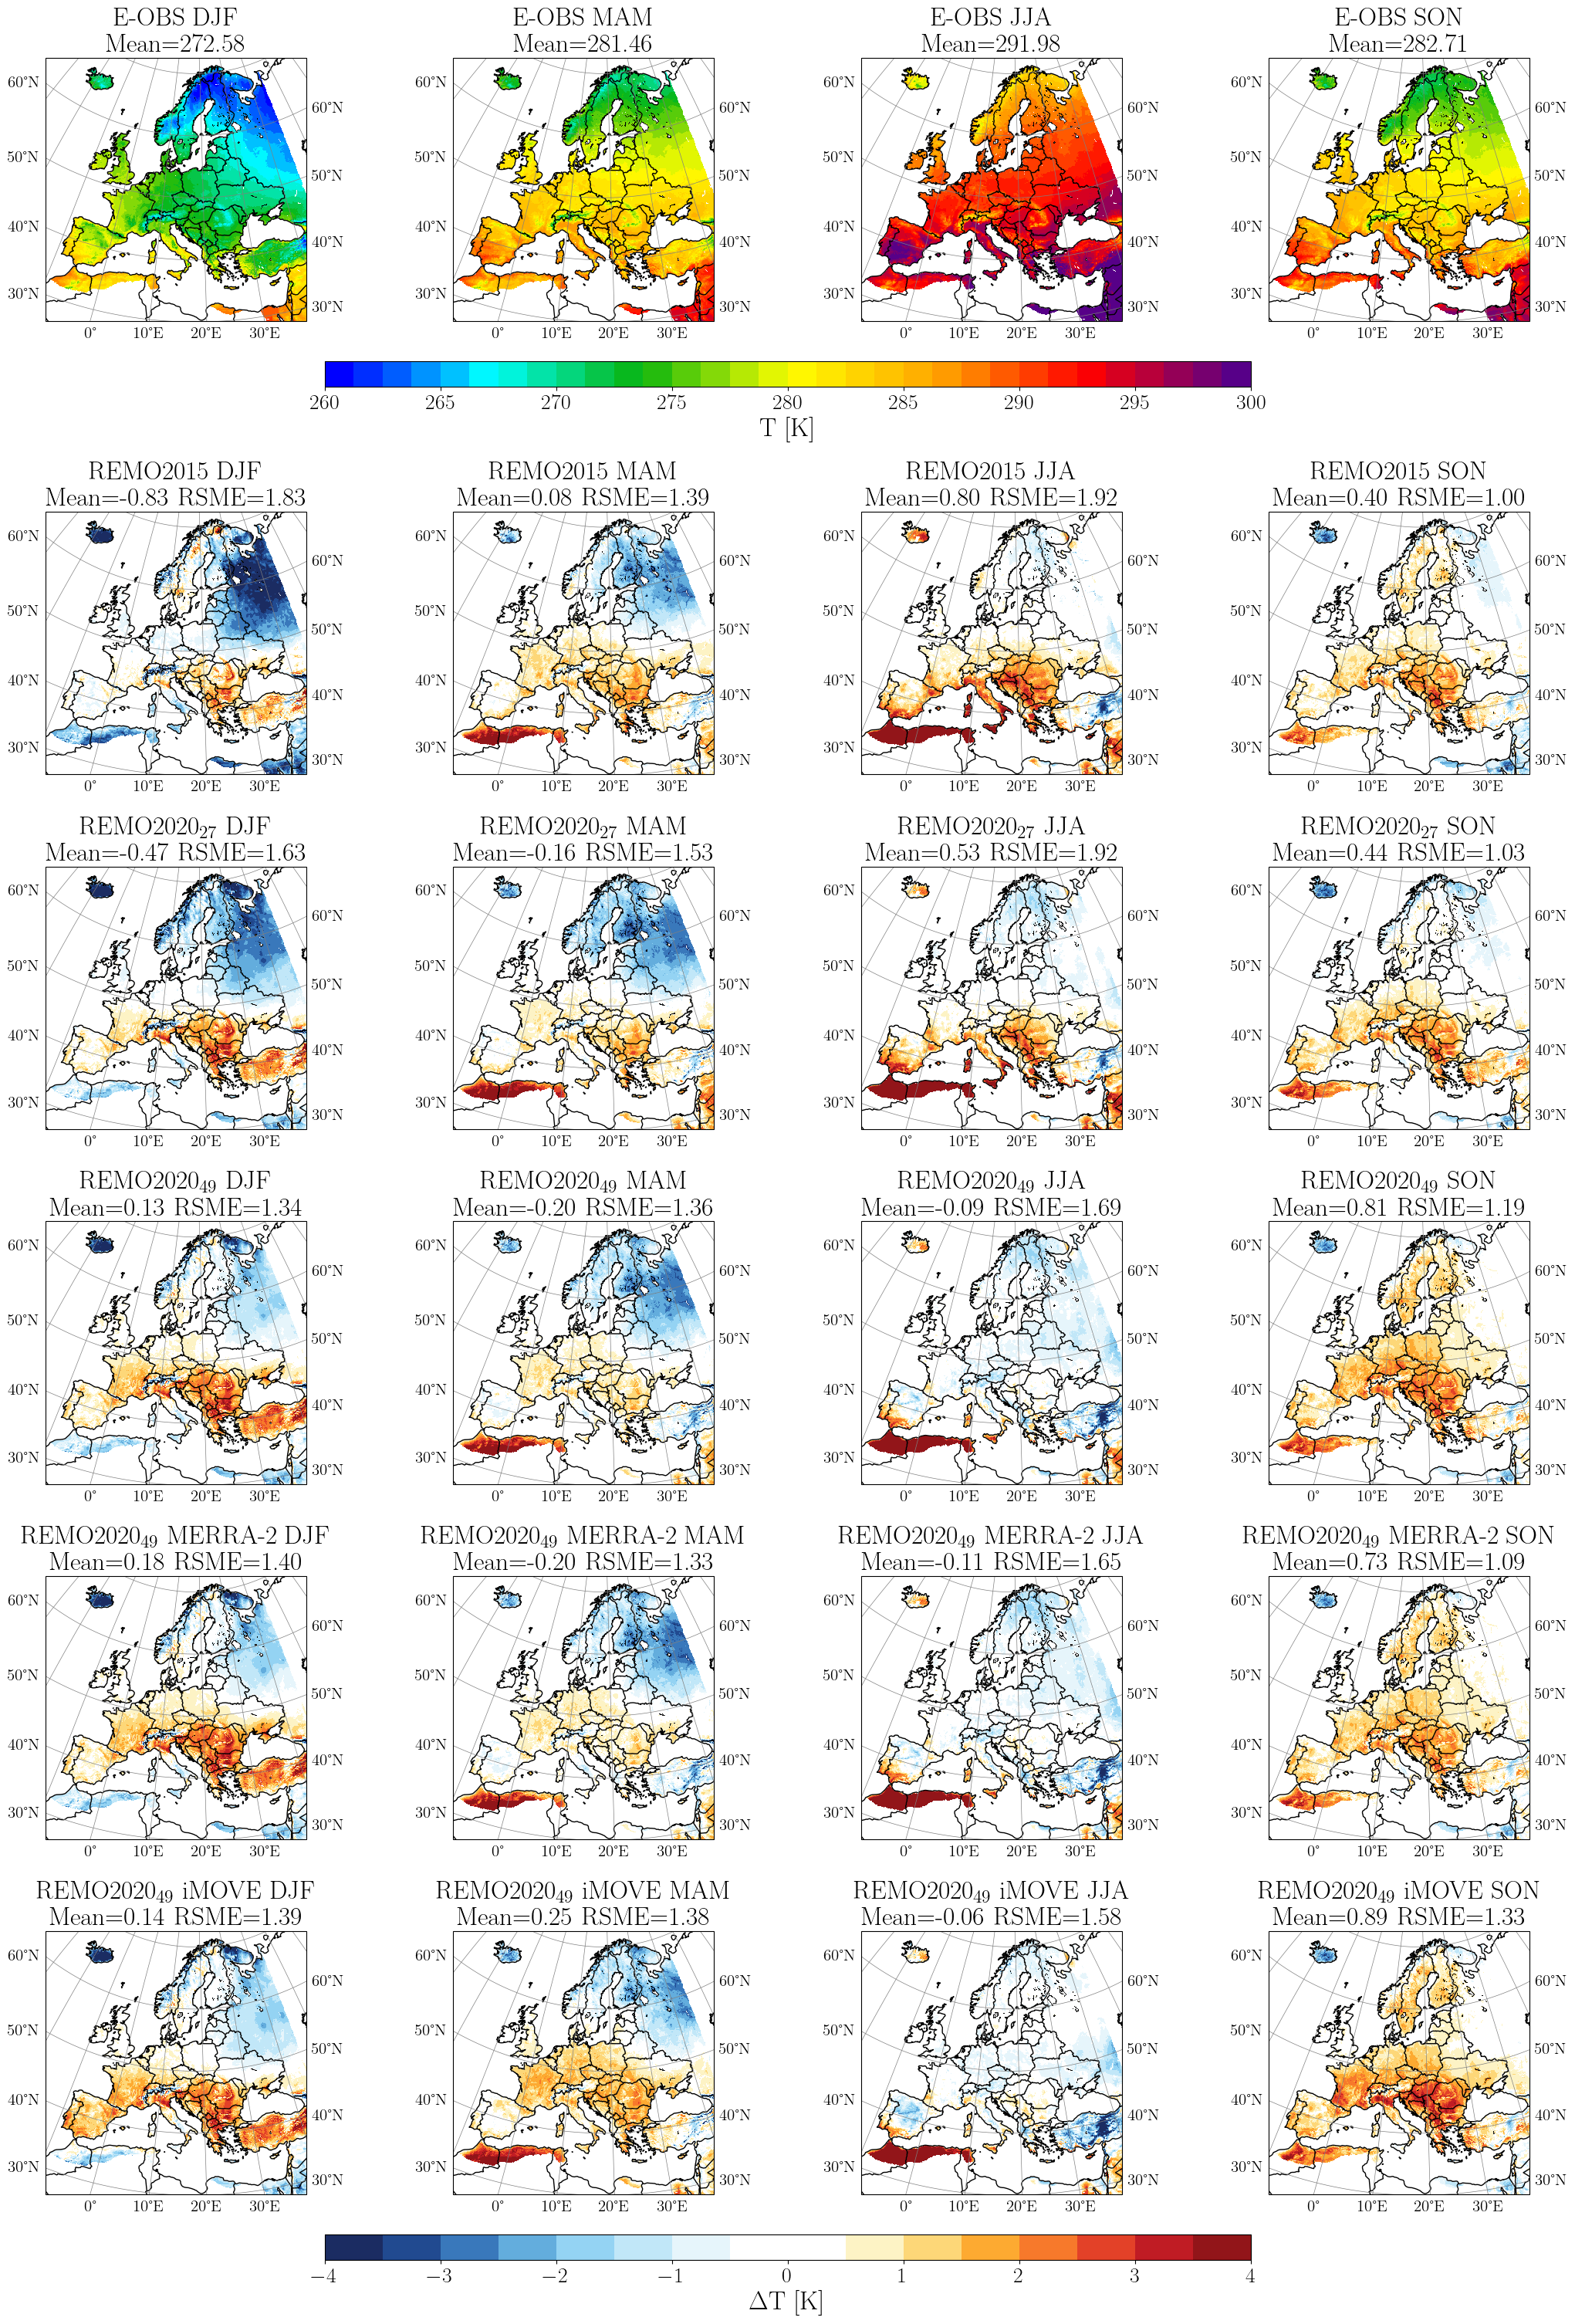

In [22]:
# Loop over domains
for dom in range(len(domaininfo)):
    # Create figure name
    figname=prefix+domaininfo[dom].name+'_'+suffix
    # Call plotter
    remo_plotter(absplotc,modplotc,domaininfo[dom],modelruns,"E-OBS",abs_vals_mean,seasons,pole,False,figpath,figname)

In [23]:
# should we dump the model difference data to disk (e.g. for further analysis, for Fig. 4)
ldump=True
dumppath=rdata+'Tpredata/'

In [24]:
if(ldump):
    for obj in modelruns:
        obj.vardiff.rename(obj.varname).to_netcdf(dumppath+'/'+obj.userexp+'_'+obj.varname+'.nc',mode='w')